# 0. Settings and Utils

In [1]:
# Required Imports
from pymongo import MongoClient
import os
import pandas as pd
from IPython.display import display
from aco.aco_final.MuseumGraphManager import MuseumGraphManager
from aco.aco_final.AlgorithmController import AlgorithmController
import json
from collections import defaultdict
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Dataframe display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# pd.reset_option('all')

In [3]:
# DB Connection
CONNECTION_URI = os.getenv("MONGO_CONNECT")
client = MongoClient(CONNECTION_URI, connect=False)
db = client.virtualmuseum
Users = db['users']

# [OPTIONAL] CAUTION!! 
# DELETE VISITS
# Users.update_one({}, {"$set": {"visits": []}})

In [4]:
# Helper Utility Functions
PHEROMONE_CATEGORIES = ["C1", "C2", "C3", "C4"]

def _classify_pheromone(pheromone, rho_min, rho_max):
    l1 = _calculate_limit_for_interval(rho_min, rho_max, 1)
    l2 = _calculate_limit_for_interval(rho_min, rho_max, 2)
    l3 = _calculate_limit_for_interval(rho_min, rho_max, 3)
    l4 = _calculate_limit_for_interval(rho_min, rho_max, 4)

    if pheromone <= l1:
        return PHEROMONE_CATEGORIES[0]
    elif l1 < pheromone <= l2:
        return PHEROMONE_CATEGORIES[1]
    elif l2 < pheromone <= l3:
        return PHEROMONE_CATEGORIES[2]
    elif l3 < pheromone <= l4:
        return PHEROMONE_CATEGORIES[3]
    else:
        raise Exception("Pheromone value is not in any interval")

def _calculate_limit_for_interval(rho_min, rho_max, interval: int):
    """ Interval [1,2,3,4] """
    return rho_min + (interval / 4) * (rho_max - rho_min)

def _get_last_iteration_of_state(current_state, current_state_index, state_list):
    previous_states = state_list[:current_state_index+1]
    iterations_elapsed = 0
    for st in previous_states:
        iterations_elapsed+= st.limit
    return iterations_elapsed
    

In [5]:
# Pickling Functions

# Load intermediate states if needed
def load_saved_state_pickles(state_pickles_dir):
    
    def custom_sort(element):
        no_extension = element.split('.')[0]
        return int(no_extension.split('_')[-1])
    
    def sort_list(input_list):
        return sorted(input_list, key=custom_sort)
        
    state_pickles = [f for f in listdir(state_pickles_dir) if isfile(join(state_pickles_dir, f)) and 'pickle' in str(f)]
    if len(state_pickles) == 0:
        print("ERROR: no saved state pickles found")
    
    sorted_state_pickles = sort_list(state_pickles)
    algorithm_states = []
    for sp in sorted_state_pickles:
        full_sp_path = f"{state_pickles_dir}/{sp}"
        state_instance = pickle.load(open(full_sp_path, 'rb'))
        algorithm_states.append(state_instance)
        print(f"Loaded state: {sp}")   
    
    return algorithm_states

def save_algorithm_states_to_pickles(controller, workdir):
    for n, algo_state in enumerate(controller.algorithm_states):
        intermediate_state_name = f"intermediate_state_{limit}iters_{n+1}"
        path_to_pkl = f"{workdir}/{intermediate_state_name}.pickle"
        pickle.dump(algo_state, open(path_to_pkl, 'wb'))
        print(f"Saved state: {intermediate_state_name}")

In [6]:
# Main Utility Functions

def get_dataframe_pheromone_categorisations_of_state(state):
    """ Categorises Pheromones into their corresponding Interval (I1, I2, I3, I4)
    for each saved state.
    The returned dataframe represents the pheromone distribution by each interval; 
    """
    # states = algorithm_controller.algorithm_states  # algorithm_controller.graph
    # for idx, state in enumerate(states):
    graph = state.graph
    rho_max = state.current_upper_bound
    rho_min = state.current_lower_bound
    data1 = {'Pheromone': [], 'Category': []}
    # data2 = {ph_cat: [0] for ph_cat in PHEROMONE_CATEGORIES}
    for edge in graph.edges():
        u, v = edge
        ph = graph[u][v]["pheromone"]
        ph_interval = _classify_pheromone(ph, rho_min, rho_max)
        data1['Pheromone'].append(ph)
        data1['Category'].append(ph_interval)

        # current_sum_in_interval = data2[ph_interval][0]
        # data2[ph_interval] = [current_sum_in_interval + 1]
    df1 = pd.DataFrame(data1)
    # df2 = pd.DataFrame.from_dict(data2)
    return df1

def get_dataframe_pheromone_distribution_across_states(states):
    df = pd.DataFrame()
    for idx, st in enumerate(states):
        graph = st.graph
        total_iterations = _get_last_iteration_of_state(st, idx, states)
        for edge in graph.edges():
            d = {"Pheromone": [], "Iteration": []}
            u, v = edge
            ph = graph[u][v]["pheromone"]
            d['Pheromone'].append(ph)
            d['Iteration'].append(total_iterations)
            df = pd.concat([df, pd.DataFrame(d)], ignore_index=True)
    return df

def train_traditional_mmas_model(algorithm_controller, total_iterations=50, save_state_every_x_iterations=10):
    if total_iterations % save_state_every_x_iterations:
        print("ERROR. Specify a checkpoint value that is multiple of the total number of iterations to compute")

    total_states_to_save = int(total_iterations/save_state_every_x_iterations)
    for i in range(total_states_to_save):
        if i == 0:
            algorithm_controller.compute_initial_iterations(limit=save_state_every_x_iterations)
        else:
            algorithm_controller.compute_next_iterations(limit=save_state_every_x_iterations)
    return algorithm_controller

In [7]:
# Main Graph Plotting Functions
def plot_pie_chart_of_pheromone_distribution_of_state(state_to_analyse, index_of_state_to_analyse, all_states,
                                                      save_plot=False, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml"):
    df = get_dataframe_pheromone_categorisations_of_state(state_to_analyse)
    total_iterations = _get_last_iteration_of_state(state_to_analyse, index_of_state_to_analyse, all_states)

    # define Seaborn color palette to use 
    palette_color = sns.color_palette('pastel') 
    
    # plotting data on chart 
    result_df = df.groupby('Category')['Pheromone'].count().reset_index(name='Count')
    plt.pie(result_df['Count'], labels=result_df['Category'],
            wedgeprops={'linewidth': 1, 'linestyle': 'solid', "edgecolor":"k"},
            autopct='%.0f%%', colors=palette_color)
    
    plt.title(f'Pheromone Distribution After {total_iterations} Iterations')
    
    # Save plot if specified
    if save_plot:
        name = f"pheromone_dist_{total_iterations}_iterations.png"
        os.makedirs(saved_plots_dir, exist_ok = True) 
        plot_fullpath = os.path.join(saved_plots_dir, name)
        plt.savefig(plot_fullpath, dpi=300)
    
    # displaying chart 
    plt.show()

def plot_pheromone_ecdf_per_state(state_to_analyse, index_of_state_to_analyse, all_states,
                                                      save_plot=False, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml"):
    
    df = get_dataframe_pheromone_categorisations_of_state(state_to_analyse)
    total_iterations = _get_last_iteration_of_state(state_to_analyse, index_of_state_to_analyse, all_states) 
    ecdf = sns.ecdfplot(data=df,x='Pheromone')
    ecdf.set(xscale="log")

    # Show Rho_min and Rho_max
    rho_max = state_to_analyse.current_upper_bound
    rho_min = state_to_analyse.current_lower_bound
    lineprops = { "ymin": 0, "ymax" : 1, "color": "black",
                 "linewidth": 0.5, "linestyle" : "dashed"}
    textprops = {"fontsize": 11, "fontstyle": "oblique", 
                 "color" : "green", "va" : "center"}
    ecdf.axvline(x = rho_min, **lineprops)
    ecdf.axvline(x = rho_max, **lineprops)
    ecdf.text(rho_min, 0.5, r'$\tau_{min}$', **textprops)
    ecdf.text(0.92*rho_max, 0.5, r'$\tau_{max}$', **textprops)

    ecdf.set(title=f"Pheromone ECDF After {total_iterations} Iterations")
    

    # Save plot if specified
    if save_plot:
        name = f"pheromone_ecdf_{total_iterations}_iterations.png"
        os.makedirs(saved_plots_dir, exist_ok = True) 
        plot_fullpath = os.path.join(saved_plots_dir, name)
        plt.savefig(plot_fullpath, dpi=300)
    
    # displaying chart 
    plt.show()

def plot_pheromone_histplot_of_state(state_to_analyse, index_of_state_to_analyse, all_states,
                                                      save_plot=False, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml"):
    df = get_dataframe_pheromone_categorisations_of_state(state_to_analyse)
    total_iterations = _get_last_iteration_of_state(state_to_analyse, index_of_state_to_analyse, all_states) 
    sns.set_palette("pastel", 2)
    hist = sns.histplot(df['Pheromone'].to_numpy(), kde=True)
    hist.set(xscale="log")
    hist.lines[0].set_color('crimson')

    # Show Rho_min and Rho_max
    rho_max = state_to_analyse.current_upper_bound
    rho_min = state_to_analyse.current_lower_bound
    print(f"RHO MIN : {rho_min}")
    max_y = hist.get_ylim()[1]
    lineprops = { "ymin": 0, "ymax" : max_y, "color": "black",
                 "linewidth": 0.5, "linestyle" : "dashed"}
    textprops = {"fontsize": 11, "fontstyle": "oblique", 
                 "color" : "green", "va" : "center"}
    hist.axvline(x = rho_min, **lineprops)
    hist.axvline(x = rho_max, **lineprops)
    hist.text(rho_min, max_y/2, r'$\tau_{min}$', **textprops)
    hist.text(0.92*rho_max, max_y/2, r'$\tau_{max}$', **textprops)

    hist.set(title=f"Pheromone Histogram After {total_iterations} Iterations")
    

    # Save plot if specified
    if save_plot:
        name = f"pheromone_histplot_{total_iterations}_iterations.png"
        os.makedirs(saved_plots_dir, exist_ok = True) 
        plot_fullpath = os.path.join(saved_plots_dir, name)
        plt.savefig(plot_fullpath, dpi=300)
    
    # displaying chart 
    plt.show()

def plot_pheromone_histplot_comparing_states(all_states):
    df = get_dataframe_pheromone_distribution_across_states(all_states)

In [13]:
# Load rooms json
with open('resources/space.json', 'r') as f:
    rooms_json = json.load(f)

# 1. MMAS Without Human Intervention

In [9]:
# Load MMAS MODEL

params = {
    'raw_museum_floorplan': rooms_json,
    'alpha': 1, # pheromone control parameter (higher value means less importance to pheromone)
    'beta': 5, # weight control parameter (higher value means less importance to weight)
    'rho': 0.05, # 0.02
    'pts': True,
    'pts_factor': 1,
    'num_ants': 5, #len(graph.nodes()),
    'start_node': 'D1-1',
    'start_room': 1
}
controller = AlgorithmController(**params)

### Train Model

In [10]:
total_iterations = 100
save_state_every_x_iterations = 25
trained_controller = train_traditional_mmas_model(controller, total_iterations=total_iterations, save_state_every_x_iterations=save_state_every_x_iterations)

Starting mmas algorithm with 25 initial iterations.
Iteration:  0
Iteration:  20
Finished computing the initial 25 iterations
Continuing mmas algorithm execution with 25 more iterations.
Iteration:  40
Done 25 iterations. Waiting for more feedback
Continuing mmas algorithm execution with 25 more iterations.
Iteration:  60
Done 25 iterations. Waiting for more feedback
Continuing mmas algorithm execution with 25 more iterations.
Iteration:  80
Done 25 iterations. Waiting for more feedback


### Analyse Pheromones

#### A. Pheromone Distribution Pie Chart (Progressive Analysis)

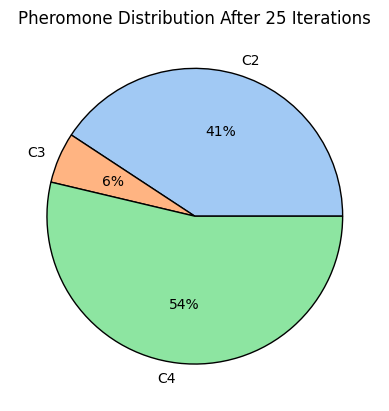

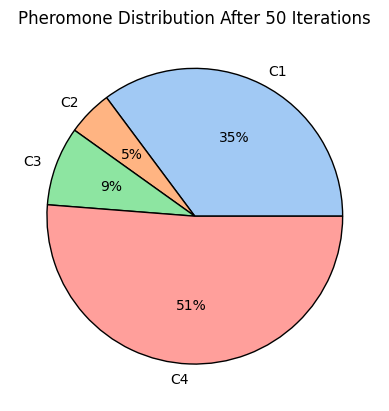

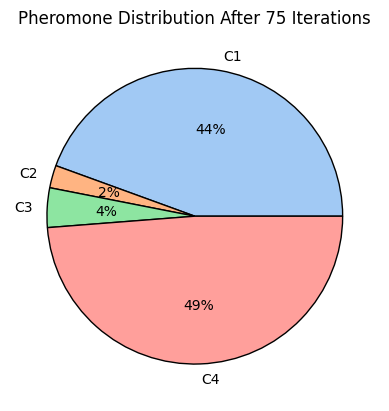

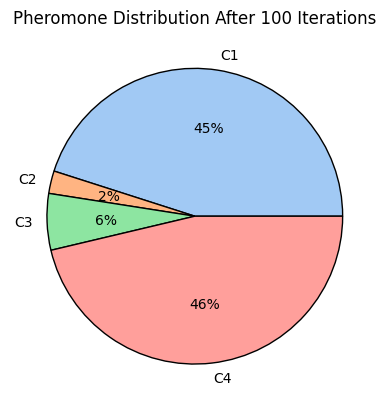

In [11]:
all_states = trained_controller.algorithm_states
for idx, state in enumerate(all_states):
    plot_pie_chart_of_pheromone_distribution_of_state(state, idx, all_states, save_plot=True, 
                                                      saved_plots_dir="evaluation_figures/mmas_no_iml")

#### B. Pheromone CDF (Progressive Analysis)

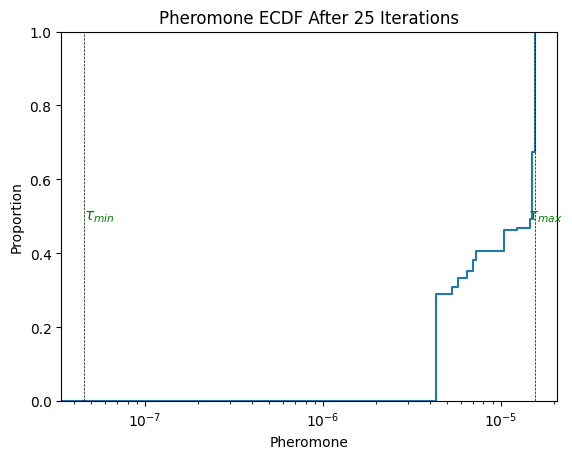

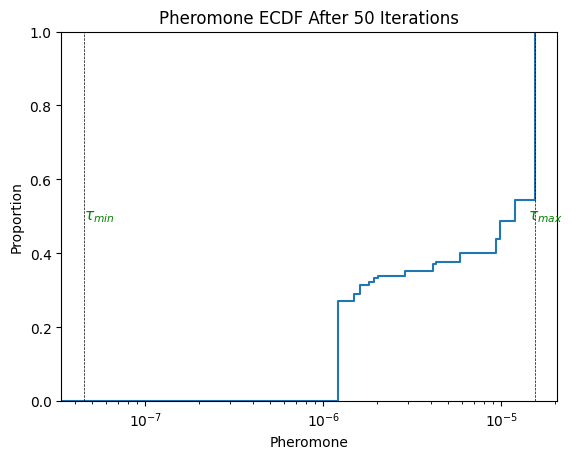

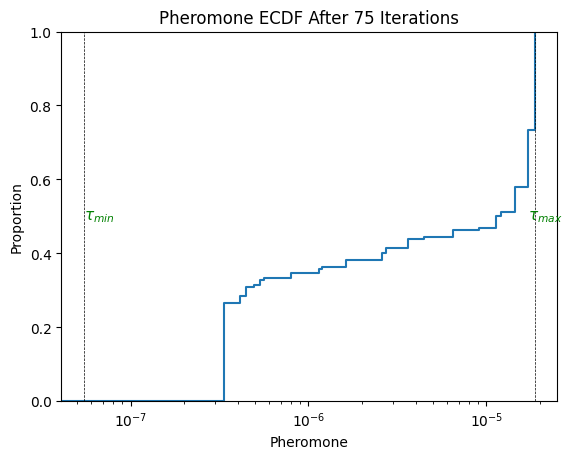

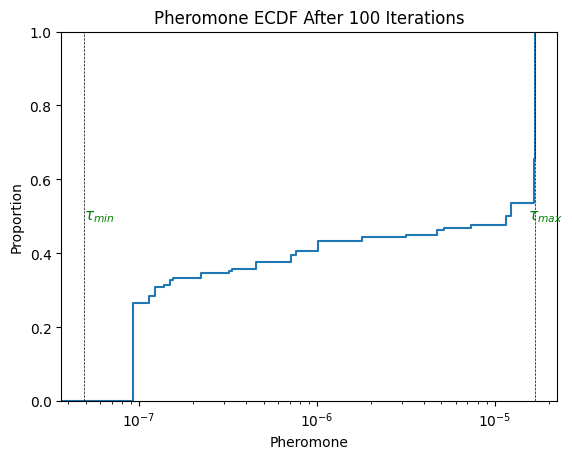

In [12]:
all_states = trained_controller.algorithm_states
for idx, state in enumerate(all_states):
    plot_pheromone_ecdf_per_state(state, idx, all_states, save_plot=True,
                                  saved_plots_dir="evaluation_figures/mmas_no_iml")

#### C. Pheromone Histogram (Progressive Analysis)

RHO MIN : 5.33178332390244e-08


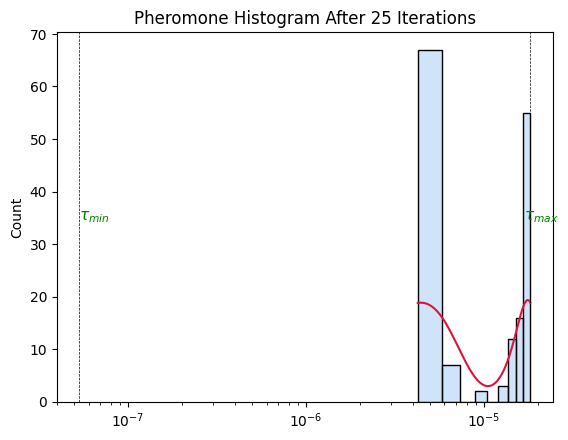

RHO MIN : 5.9401174470209846e-08


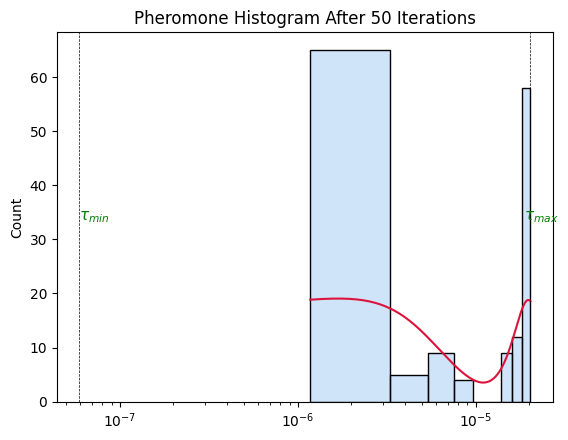

RHO MIN : 6.168873523674197e-08


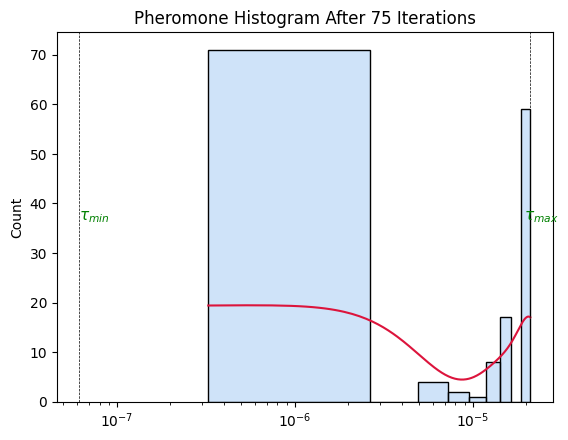

RHO MIN : 6.407626627583311e-08


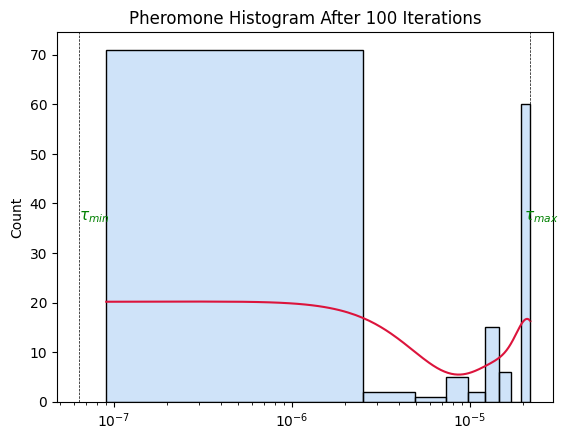

In [76]:
all_states = trained_controller.algorithm_states
for idx, state in enumerate(all_states):
    plot_pheromone_histplot_of_state(state, idx, all_states, save_plot=True,
                                  saved_plots_dir="evaluation_figures/mmas_no_iml")

#### D. Pheromone Histplot, ECDF & ViolinPlot (Comparative Analysis)

In [91]:
df_all_states = get_dataframe_pheromone_distribution_across_states(all_states)

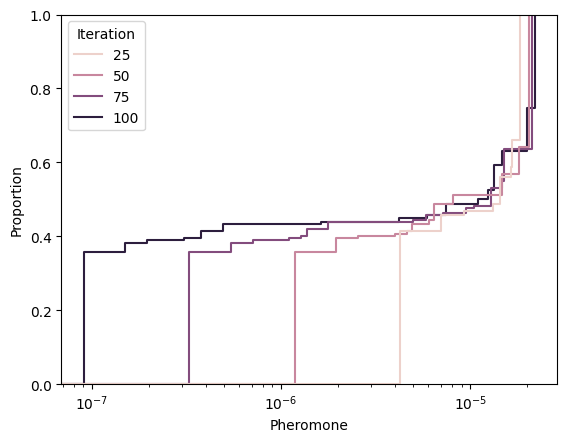

In [92]:
comp_ecdf = sns.ecdfplot(data=df_all_states,x='Pheromone', hue="Iteration")
comp_ecdf.set(xscale="log")
plt.show()

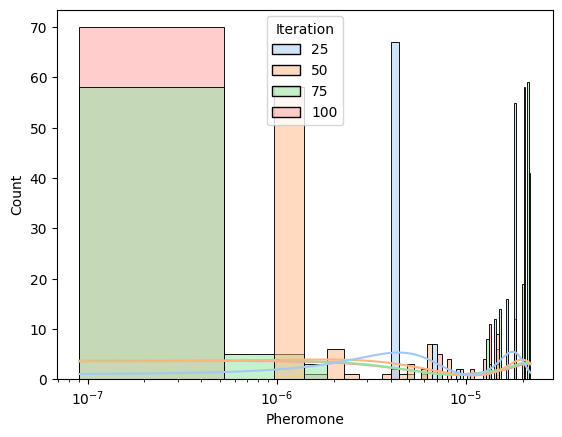

In [93]:
comp_hst = sns.histplot(data=df_all_states, x='Pheromone', hue='Iteration', palette="pastel", kde=True, bins=50)
comp_hst.set(xscale="log")
plt.show()

<Axes: ylabel='Pheromone'>

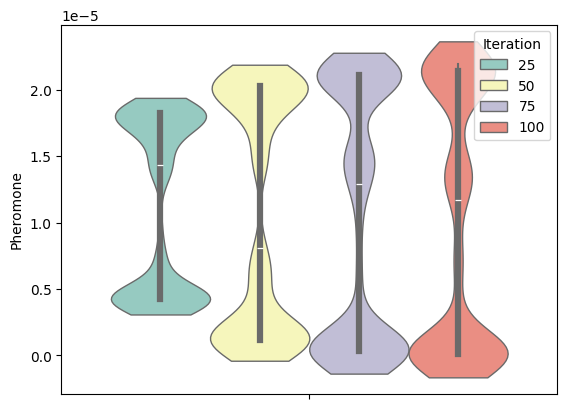

In [94]:
# https://seaborn.pydata.org/examples/wide_form_violinplot.html
comp_vp = sns.violinplot(data=df_all_states, hue='Iteration', y='Pheromone', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")
comp_vp.set(yscale="log")

# 2. MMAS iML

In [ ]:
# Get user with all visits
user_info = Users.find_one({}, {"visits":1, "username": 1, "_id": 0})
all_visits = user_info["visits"]
valid_visits = list(filter(lambda v: (isinstance(v,list) and len(v) > 1), all_visits))
print(f"{len(valid_visits)} visits registered.")

In [ ]:
# Make a list where each element is a dataframe representing each different visit
visits_dfs = []
for visit in valid_visits:
    df = pd.DataFrame.from_dict(visit)
    visits_dfs.append(df)

# Print Info on Visits
for idx, visit_df in enumerate(visits_dfs):
    
    print("**************")
    print(f"Visit {idx+1}")
    print("**************")
    
    display(df.head())
    print("\n")
    
print("-------------------")
print(f"TOTAL VISITS: {len(visits_dfs)}")

In [ ]:
# MMAS Model SOLO Training (No Interactive Feedback)
controller.compute_initial_iterations(limit=5)
cdf = controller.pheromone_info(use_dataframe=True)
# display(cdf)

In [ ]:
controller.manual_pheromone_and_continue_iters(('D1-1', 'The Nobleman with his Hand on his Chest'), multiplier=10000, limit=5)
#controller.compute_next_iterations(limit=15)
cdf = controller.pheromone_info(use_dataframe=True)
# display(cdf)